|**Name**| **ID #** | **Email** | **When Midterm**| 
| :--     |  :--      |  :--    | :--             |           
|Xuan Xu |   111675940 | xuaxu@cs.stonybrook.edu        | 10/9                |             
|Hae-Na Lee| 111207004 | haenalee@cs.stonybrook.edu | 10/13, 10/23 |            
|Caitao Zhan| 111634527| caitao.zhan@stonybrook.edu | 10/16  |



In [2]:
# import all packages needed

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import datetime, time
import copy
import random

from sklearn import preprocessing
from sklearn import linear_model
from sklearn.metrics.pairwise import manhattan_distances as man_dis
from sklearn.metrics.pairwise import euclidean_distances as euc_dis

from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN

In [4]:
# Separately maintain both the raw data and its cleaned version.

df_house16 = pd.read_csv('../data/properties_2016.csv')
df_train16 = pd.read_csv('../data/train_2016_v2.csv')

df_house17 = pd.read_csv('../data/properties_2017.csv')
df_train17 = pd.read_csv('../data/train_2017.csv')

D:\Program Files\anaconda\lib\site-packages\IPython\core\interactiveshell.py:2717: DtypeWarning: Columns (22,32,34,49,55) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


# 1. Scoring function to rank houses

## 1.1 Scoring function

A scoring function is designed to rank houses by desirability, which reflects cost or value.
We selected the housing variables considered to be effective on the housing value. The real-estate site ([1]) emphasized that property location is important and also mentioned that the factors such as physical state, neighborhood and layout affect property price. Therefore, the following variables are chosen to be used for the scoring function:

|  | Variable |
|:--|:--|
|1| *bedroomcnt* |
|2| *buildingqualitytypeid* |
|3| *calculatedbathnbr* |
|4| *calculatedfinishedsquarefeet* |
|5| *lotsizesquarefeet* |
|6| *yearbuilt* |

The scoring function is a linear combination of normalized variable values. The vital variables such as *buildingqualitytypeid* and *calculatedfinishedsquarefeet* are given higher weights than those of other variables.

Variables relevant to housing location (e.g. *latitude*, *longitude*) are not used to build the scoring function. Instead they are utilized to verify how well the scoring function works.

`[1]`: 10 Timeless Factors That Affect Property Price, http://www.propertylogy.com/knowledge/10-timeless-factors-that-affect-property-price/

In [8]:
# Read the property data
property_2017 = df_house17

In [9]:
# Extract the features to analyze
feature_list = ['parcelid','bedroomcnt','buildingqualitytypeid',
                'calculatedbathnbr','calculatedfinishedsquarefeet',
                'lotsizesquarefeet','yearbuilt','structuretaxvaluedollarcnt',
                'latitude','longitude','regionidcity','regionidzip']

feature_2017 = property_2017[feature_list]

In [10]:
# Fill in missing feature data with mean values
model_dataset_filled_2017 = feature_2017.fillna(feature_2017.mean())

In [11]:
# Preprocessing Step
#model_dataset_norm = model_dataset
model_dataset_norm = model_dataset_filled_2017

# Normalize the features with skewed distributions
model_dataset_norm.calculatedbathnbr = np.log(model_dataset_norm.calculatedbathnbr)
model_dataset_norm.calculatedfinishedsquarefeet = np.log(model_dataset_norm.calculatedfinishedsquarefeet)
model_dataset_norm.lotsizesquarefeet = np.log(model_dataset_norm.lotsizesquarefeet)
#model_dataset_norm.roomcnt = np.log(model_dataset_norm.roomcnt)
model_dataset_norm.structuretaxvaluedollarcnt = np.log(model_dataset_norm.structuretaxvaluedollarcnt)

In [12]:
# Normalize all features

model_dataset_norm.loc[:,'bedroomcnt':'structuretaxvaluedollarcnt'] = \
 preprocessing.scale(model_dataset_norm.loc[:,'bedroomcnt':'structuretaxvaluedollarcnt'])

In [13]:
# Scoring function
feature_list = ['parcelid','bedroomcnt','buildingqualitytypeid',
                'calculatedbathnbr','calculatedfinishedsquarefeet',
                'lotsizesquarefeet','yearbuilt',
                'structuretaxvaluedollarcnt','latitude','longitude','regionidcity','regionidzip']
scoring_dataset = model_dataset_norm[feature_list]

desirability_score = pd.DataFrame(scoring_dataset.bedroomcnt*0.8
 - scoring_dataset.buildingqualitytypeid
 + scoring_dataset.calculatedbathnbr*0.8
 + scoring_dataset.calculatedfinishedsquarefeet
 + scoring_dataset.lotsizesquarefeet*0.8
 + scoring_dataset.yearbuilt, columns=['score'])

# simple linear combination
# structuretaxvaluedollarcnt
# most desirables: 3.921996353698721
# lease desirables: -0.4135856986788523

In [14]:
# Append the desirability score to the dataset
scoring_result = pd.concat([scoring_dataset, desirability_score], axis=1)

## 1.2 Distribution of desirability scores

The histogram shows the distribution of desirability scores.

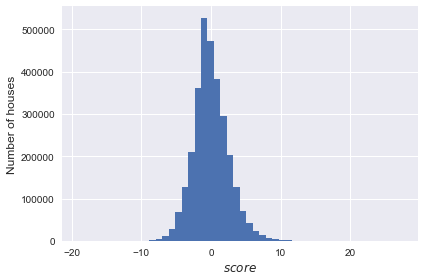

In [16]:
# Plot. Histogram of score
num_bins = 50
ax = plt.subplot()
n, bins, patches = ax.hist(scoring_result.score, num_bins)

ax.set_xlabel('$score$', fontsize=12)
ax.set_ylabel('Number of houses', fontsize=12)
#ax.set_title('Histogram of $score$', fontsize=12)

plt.tight_layout()
plt.show()

## 1.3 Ranking scores

The scores were ranked to figure out the most and least desirable houses. The variable *regionidcity* is also included in the scoring tables for analysis. It is used to decide whether the most desirable or least desirable houses are located in common areas.

### 1.3.1 The most desirable houses

The score table and strip plot show the tendency of the most desirable houses. Among the ten most desirable houses, six houses are found to be located in the same city. The city is identified to have the variable *regionidcity* value of 12447.

In [17]:
# Sort based on scores
scoring_result_ordered = scoring_result.sort_values('score', ascending=False)

In [18]:
# Get the ten most desirable houses in the dataset
most_desirables = scoring_result_ordered[:10]
most_desirables = most_desirables.reset_index(drop=True)

most_desirables.index = most_desirables.index + 1
most_desirables.loc[:,['parcelid','score','regionidcity']]

,parcelid,score,regionidcity
1,11779475,27.336368,12447.000000
2,12325767,23.707704,6395.000000
3,10960072,21.260040,396054.000000
4,11641900,20.314718,12447.000000
5,11642367,20.284545,12447.000000
6,11645396,20.189754,12447.000000
7,11349969,19.936472,10734.000000
8,167638338,19.771696,34987.659995
9,11654998,19.508479,12447.000000
10,12651052,19.482287,12447.000000


The strip plot of the most desirable houses is drawn using the variable *regionidcity* and scores. Since *regionidcity* is distinct to each city and it is a categorical data, plotting as a strip plot is suitable.

In particular, the plot indicates that there are more houses with the scores between 19 and 21 regardless of *regionidcity* values. The top-ranked house is outstanding with the highest score of 27.336368.

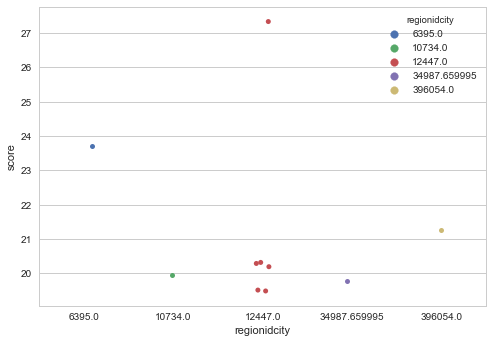

In [22]:
# Stripplot of the most desirable housing scores
sns.set(style="whitegrid", color_codes=True)

ax = plt.subplot()
sns.stripplot(x="regionidcity", y="score", hue="regionidcity", data=most_desirables, jitter=True)

We found out the location of the most desirable houses with variables *longitude* and *latitude*. For the most desirable housing data, the average values of *longitude* and *latitude* were calculated to locate a city on the map. Those values indicated Beverly Hills in Los Angeles County, which is a plausible area to have a number of valuable houses.

In [23]:
# Compute the average location of most desirable houses
print('Average location of most desirable houses')
print(' Longitude : ' + str(most_desirables['longitude'].mean()/1e+6))
print(' Latitude : ' + str(most_desirables['latitude'].mean()/1e+6))

Average location of most desirable houses
 Longitude : -118.373906
 Latitude : 34.0631053


![LatLong mostdesirables](./figure/LatLong_mostdesirables.png)

### 1.3.2 The least desirable houses

The same analysis was performed for the least desirable houses. However, the least desirable houses found with the scoring function does not show a specific tendency. Most of them are spread across the regions. 

In [24]:
# Get the ten least desirable houses in the dataset
least_desirables = scoring_result_ordered[-10:]
least_desirables = least_desirables.reset_index(drop=True)

least_desirables.index = least_desirables.index + 1
least_desirables.loc[:,['parcelid','score','regionidcity']]

,parcelid,score,regionidcity
1,11243663,-15.884499,13232.0
2,11651552,-16.064363,12447.0
3,12152324,-16.081543,396551.0
4,12660907,-16.139544,33612.0
5,12147406,-16.657134,50749.0
6,11490532,-16.866039,33612.0
7,12586087,-17.343808,10723.0
8,12201284,-18.629019,396053.0
9,12546681,-18.833180,46298.0
10,12186499,-19.060037,396053.0


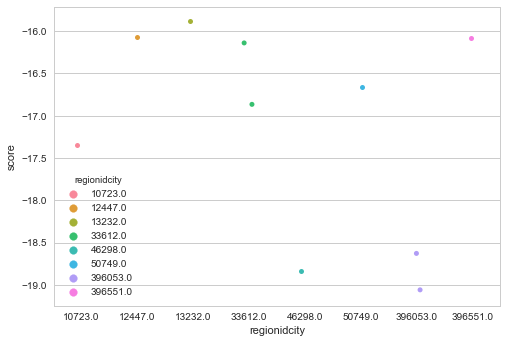

In [25]:
# Stripplot of the least desirable housing scores
sns.stripplot(x="regionidcity", y="score", hue="regionidcity", data=least_desirables, jitter=True)

# 2 Task Two: Design Pairwise Distance Function

Many algorithms in machine learning and data mining require a *pairwise distance function (distance function)* as a basic component. This chapter shows our insights and efforts on building decent distance functions. **First** we fill elaborate on our four steps of designing a distance function. **Then** introduce a baseline distance function. **Finally** we will introduce an advanced distance function.

## 2.1 Four Steps
We break down designing a pairwise distance function into four steps, as follows:

| Step | Description | Memo |
|:--|:--|:--|
|1| feature selection| curse of high dimension :( |
|2| impute missing value| what is the distance between two NaN ?! |
|3| normalization| z-score ~ |
|4| what kind of distance| $L_k\ (k = ?)$|

### 2.1.1 Feature Selection

In high dimensional space, the concept of proximity, distance or nearest neighbor may not be qualitatively meaningful[[1]]. For example, in high dimensions, the performance of similarity indeing structures degrades rapidly, thus each query requires the access of almost all the data[[2]]. In english, this is known as *curse of dimensionality*[[3]]. 

`[1]`: Charu C. Aggarwal, Alexander Hinneburg, and Daniel A. Keim. "On the Surprising Behavior of Distance Metrics in High Dimensional Space".

`[2]`: Weber R., Schek H.-J., Blott S.. "A Quantitative Analysis and Performance Study for Similarity-Search Methods in High-Dimensional Spaces". VLDB Conference Proceedings, 1998.

`[3]`: Wikipedia: Curse_of_dimensionality


[1]:https://bib.dbvis.de/uploadedFiles/155.pdf
[2]:https://pdfs.semanticscholar.org/63ea/eb0c48175065ffd096aad10aed712c6d7bbb.pdf
[3]:https://en.wikipedia.org/wiki/Curse_of_dimensionality



### 2.1.2 Distance Between Missing Values

The **distance between two missing values** is an annoying part when designing a distance function. Of course, an easy way is replacing all the *NaN* with *mean*. But we do not think this is a good idea. The reason is as follows:

**mean == mean**, but **np.nan != np.nan**.

Suppose there is a feature named *bathroomcnt*. So, when replacing *NaN* with *mean*, then the distance of two *bathroomcnt = NaN* will be zero (*mean* - *mean* = 0). However, we believe the distance should not be zero. The distance should be zero, for example, when two houses both have 2 bathrooms.

After hard thinking, we finally decide to use the **random value imputation** method to replace *NaN*. It replaces *NaN* with a random value **sampled from its column (feature)**. Then the distance between two original *NaN* will be a *random value*. This will be a lot better than a *zero* distance.

Furthermore, if one is a numeric number and the other is *NaN*, then the distance will be that numeric value minus a random value sampled from its column.

In [8]:
def randomSampleImpute(df, feature_list):
    """ Replace NaN with a random value sampled from its column(feature).
    
    Args:
        df (pandas.DataFrame): data set
        feature_list   (list): a list of features, each element is a string
    """
    
    for col in feature_list:
        nan_indexes = np.argwhere(np.isnan(df[col]))             # which rows have NaN, array
        valid_series = df[col].dropna()                          # drop the NaN, Series
        random_values = valid_series.sample(n=nan_indexes.size)  # random samples, Series
        
        for nan_index, random_value in zip(nan_indexes, random_values):
            df.iat[nan_index[0], df.columns.get_loc(col)] = random_value  # replace NaN

### 2.1.3 Normalization

If we do not normalize our variables before computing distances, there will be serious biases and screw up the distance metrics. Thus, we have to first normalize the values of each dimension by Z-scores, then compute distances.

$$Z_i = (a_i-\mu )/\sigma $$

where $\mu$ is the mean of the distribution and $\sigma$ the associated standard deviation.

Also, whenever we detect a specific feature's distribution is skewed, we might need to log that feature.

In [9]:
def z_score_norm(df, feature_list):
    """ Dot the z-score method on selected features in feature_list. 
        z = (x - mean)/std
    
    Args:
        df (pandas.DataFrame): data set
        feature_list   (list): a list of features, each element is a string
    """
    
    for col in feature_list:
        df[col] = (df[col] - df[col].mean())/(df[col].std())

### 2.1.4 What Kind of Distance

*Manhatten* distance and *euclidian* distance are two commonly used distances. Actually, they are just two special cases of $L_K$ distance metric or norm, where *K=1* and *K=2* respectively.

Research results[[1]] show that Manhattan distance metric ($L_1$ norm) is consistently more preferable than the Euclidean distance metric ($L_2$ norm) for high dimensional data science applications.

[1]:https://bib.dbvis.de/uploadedFiles/155.pdf

`[1]`: Charu C. Aggarwal, Alexander Hinneburg, and Daniel A. Keim. "On the Surprising Behavior of Distance Metrics in High Dimensional Space".

## 2.2 Baseline Distance Function
A simple baseline distance function will only be based on two features: **[longiude, latitude]**. The metrics is **euclidiean**.

### 2.2.1 Design
Britain real estate tycoon Harold Samuel said: 'There are three things that matter in property: location, location, location.' Let's visualize where are the locations of the properties in the data provided by [Kaggle](https://www.kaggle.com/c/zillow-prize-1/data).

In [ ]:
def pairwise_distance_baseline(s1, s2, feature_list):
    """ Compute the distance between two series using euclidian distance. 
    
    Args:
        s1 (Series): a row in a dataframe, i.e. a property.
        s2 (Series): a row in a dataframe, i.e. a property.
    """
    X  = feature_list[0]
    Y  = feature_list[1]
    x1 = s1.at[X]
    y1 = s1.at[Y]
    x2 = s2.at[X]
    y2 = s2.at[Y]
    return euc_dis([[x1,y1]], [[x2,y2]])

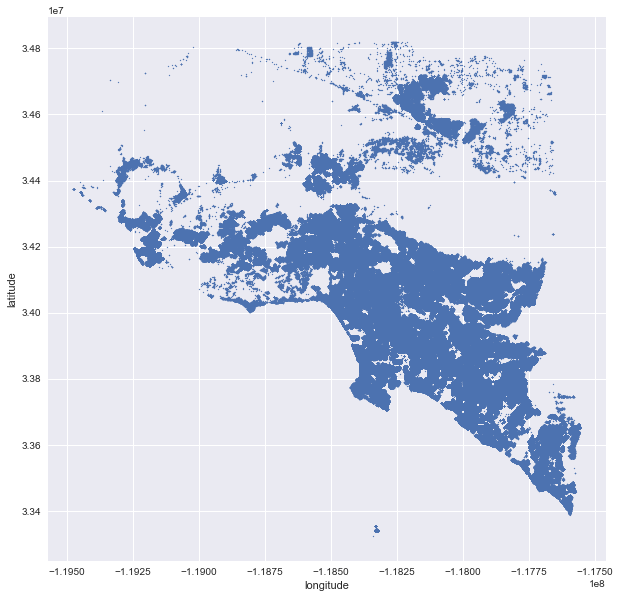

In [4]:
X = 'longitude'
Y = 'latitude'

df_ll = df_house16.loc[:,[X, Y]]
df_ll.dropna(how='any', inplace=True)
df_ll.plot.scatter(x=X, y=Y, s=1, figsize=(10,10))

![los angeles](./figure/los_angeles.png)

After visualizing *longitude* and *latitude* and comparing them to google maps, we can find out that all the properties are in the greater Los Angeles area. Our **baseline distance function** will **only be based on locations: (longitude, latitude)**.

### 2.2.2 Example 
In this section, we will caculate the distance between two randomly selected properites. 

First clean the data.

In [8]:
# Operate the raw data and cleaned data separately.
df_house16_clean = copy.deepcopy(df_house16)

In [9]:
feature_list = ['longitude', 'latitude']
randomSampleImpute(df_house16_clean, feature_list)   # Missing value imputation
z_score_norm(df_house16_clean, feature_list)         # Normalization

Then calculate the distance between two randomly selected properties.

In [14]:
row1 = random.randint(0, 2985217)
row2 = random.randint(0, 2985217)

dis = pairwise_distance_baseline(df_house16_clean.iloc[row1], df_house16_clean.iloc[row2], feature_list)
print('The distance between #%d and #%d is %f' % (row1, row2, dis))

The distance between #693607 and #1955271 is 1.175066


In [15]:
del df_house16_clean                                 # release memory

## 2.3 Advanced Distance Function
Our advanced distance function will contain four dimensions: **['longitude', 'latitude', 'calculatedfinishedsquarefeet', 'yearbuilt']**, using **manhattan** distances.

### 2.3.1 Design

Comparing to baseline distance function with only two geographic features, we added *calculatedfinishedsquarefeet* and *yearbuilt* in the advanced distance function. This is because we believe these two are typical features for a property. 


||Dimension|
|:--|:--|
|1| longitude |
|2| latitude  |
|3| calculatedfinishedsquarefeet|
|4| yearbuilt|


In [5]:
def pairwise_distance_advance(row1, row2):
    """ Compute the distance between two properties using manhattan distance. 
    
    Args:
        s1 (1d array): a row in a matrix, i.e. a property.
        s2 (1d array): a row in a matrix, i.e. a property.
    """
        
    x1 = row1[0]  # 'longitude'
    y1 = row1[1]  # 'latitude'
    a1 = row1[2]  # 'calculatedfinishedsquarefeet'
    b1 = row1[3]  # 'yearbuilt'
    
    x2 = row2[0]
    y2 = row2[1]
    a2 = row2[2]
    b2 = row2[3]
    
    return abs(x2-x1) + abs(y2-y1) + abs(a2-a1) + abs(b2-b1)  # manhattan

### 2.3.2 Experiment

Experiment method: 

1. Do data cleaning.
2. Randomly choose a specific property $P$.
3. Compute the distance of $P$ to every property.
4. Visualize the distance distribution.

1) First deep copy the original raw data.

In [6]:
df_house16_clean = copy.deepcopy(df_house16)

2) Select four dimensions.

In [7]:
feature_list_ad = ['longitude', 'latitude', 'calculatedfinishedsquarefeet', 'yearbuilt']
df_house16_clean = df_house16_clean[feature_list_ad]

3) Randomly impute missing values by sampling.

In [11]:
randomSampleImpute(df_house16_clean, feature_list_ad)

4) Z-score the dimensions. Before z-scoring, np.log the calculatedfinishedsquarefeet since it's skrewed.

In [13]:
df_house16_clean.calculatedfinishedsquarefeet = np.log(df_house16_clean.calculatedfinishedsquarefeet)
z_score_norm(df_house16_clean, feature_list_ad)

In [20]:
df_house16_clean.head()

,longitude,latitude,calculatedfinishedsquarefeet,yearbuilt
0,-1.309366,0.587439,1.445885,-0.395162
1,-1.226195,0.570955,-0.369253,1.609709
2,-0.558016,-0.049759,8.477599,-1.632210
3,-0.681304,0.605604,2.528379,-0.693760
4,-0.532483,0.791751,0.190091,-0.736417


5) After data cleaning, let's calculate the distances.

In [21]:
size  = df_house16_clean.shape[0]         # size = 2985217
mat   = df_house16_clean.as_matrix()      # transform to matrix, this way is faster.
index = random.randint(0,size)            # a random index
p     = mat[index]                        # pick a random property P

array_dis = np.zeros(shape=(size,))       # an array to store the distances of $P$ to every property

for i in range(size):
    row = mat[i]
    array_dis[i] = pairwise_distance_advance(p, row)  # call the distance function

6) Visualize the distance distribution.

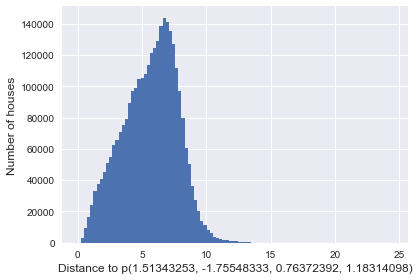

In [32]:
df_dis = pd.DataFrame(array_dis, columns=['distance'])      # from array to dataframe
df_result = pd.concat([df_house16_clean, df_dis], axis=1)   # insert the distances into df_house16_clean

# Plot. Histogram of distance
num_bins = 100
ax = plt.subplot()
n, bins, patches = ax.hist(df_result.distance, num_bins)

ax.set_xlabel('Distance to p(1.51343253, -1.75548333, 0.76372392, 1.18314098)', fontsize=12)
ax.set_ylabel('Number of houses', fontsize=12)

plt.tight_layout()
plt.show()

7) Show the nearest neighbors of **P** = (1.51343253, -1.75548333, 0.76372392, 1.18314098)

In [35]:
df_result[df_result.distance<0.01]

,longitude,latitude,calculatedfinishedsquarefeet,yearbuilt,distance
131290,1.515138,-1.756354,0.763724,1.183141,0.002577
250308,1.512399,-1.760110,0.763724,1.183141,0.005660
309674,1.518581,-1.756498,0.763724,1.183141,0.006164
428906,1.515489,-1.760533,0.763724,1.183141,0.007106
547797,1.513821,-1.752739,0.763724,1.183141,0.003133
577547,1.516598,-1.756856,0.763724,1.183141,0.004538
1261765,1.515500,-1.755282,0.763724,1.183141,0.002269
1410480,1.514469,-1.758232,0.763724,1.183141,0.003785
2005265,1.518564,-1.754596,0.763724,1.183141,0.006019
2124193,1.513997,-1.761227,0.763724,1.183141,0.006309


### 2.3.3 Discussion

First, we show our reasons why we add 2 property-specific features(*calculatedfinishedsquarefeet* and *yearbuilt*) above the simple baseline distance function, and formed a four dimensional distance function. The caculated finished square feet area is probably the most important attribute a person cares except the location. In similar locations, a larger house is mostly more valuable than a smaller house and a better place to live in. Year built is also a critical attribute for a house. Year built is correlated to many interesting features of a property. For example, people lived in different decades may prefer different architectual styles. In the 1950s, many people prefered raised ranch style houses and many that kind houses are build at that time period.

Second, we tell why we decided to use the *mahanttan* distance. According to section 2.1.4, Manhattan distance metric ($L_1$ norm) is consistently more preferable than the Euclidean distance metric ($L_2$ norm) for high dimensional(n>3) data science applications.

Third, we explain how we come up with our experiment method. We have nearly 3 million rows in a dataframe. It is quite impractical to compute the distances of every pair of rows, since doing so will need a 3 million $\times$ 3 million matrix to store the results. So instead, we randomly pick a specific property **P**, then compute the distances of **P** to every properties.

Fourth, we looked at the results of our advanced distance function, it looks pretty well. Below are the evaluation. We visualized the distance distribution. According to the figure, **distance = 7** is a threshold. When **distance < 7**, the Y value of the histogram grows almost linearly. The peak Y value is just above 140,000. Which means that there are 140,000 properties whose distance wich **P** is 7. When **distance > 7 **, the Y value first decreases rapidly almost linearly, then the decrease rate gets slower and slower. We printed some near neighbors of **P** who has a distance less than 0.01. No surprisingly, the nearest neighbors have a very close value on all four dimensions. **We picked the ($L_1$ norm) distance metrics  to reward properties for being close on all four dimensions**.

Fifth, we tried to interpret the meanings of our high dimension distance function. However, we figured out we can **hardly tell the geometric sense** of it. The only thing we are sure is that, according to our distance function, these properties are close to each other or far from each other.

To sum up, a simple distance function and a carefully designed advanced distance function all work well as we expected. 

# 3 Task 3: Clustering

## 3.1 KMeans + Euclidean

In [6]:
feature_list = ['longitude', 'latitude']
df_ll = df_house16[feature_list]

In [ ]:
randomSampleImpute(df_ll, feature_list)
z_score_norm(df_ll, feature_list)

In [10]:
kmeans = KMeans(init='k-means++', n_clusters=15)
kmeans.fit(df_ll)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=15, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

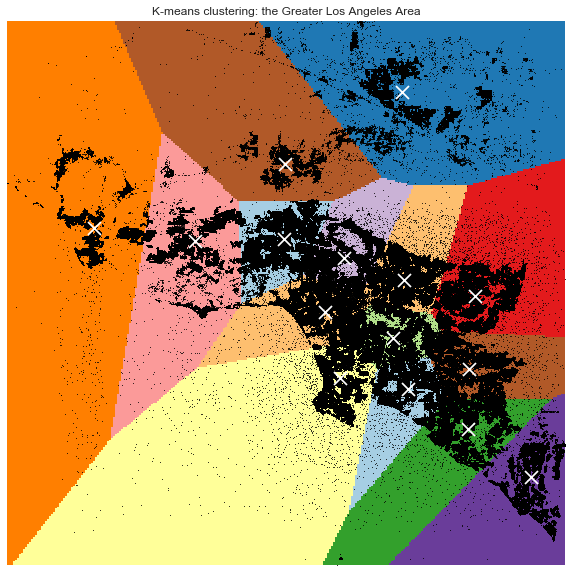

In [11]:
# Step size of the mesh. Decrease to increase the quality of the VQ.
h = .02     # point in the mesh [x_min, x_max]x[y_min, y_max].

# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = df_ll.iloc[:, 0].min(), df_ll.iloc[:, 0].max()
y_min, y_max = df_ll.iloc[:, 1].min(), df_ll.iloc[:, 1].max()
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Obtain labels for each point in mesh. Use last trained model.
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(figsize=(10,10))
plt.clf()
plt.imshow(Z, interpolation='nearest',
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap=plt.cm.Paired,
           aspect='auto', origin='lower')

plt.plot(df_ll.iloc[:, 0], df_ll.iloc[:, 1], 'k.', markersize=2)
# Plot the centroids as a white X
centroids = kmeans.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1],
            marker='x', s=169, linewidths=3,
            color='w', zorder=10)
plt.title('K-means clustering: the Greater Los Angeles Area')
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()

## 3.2 DBSCAN + Manhanttan (our own advanced distance function)

DBSCAN: **D**ensity-**B**ased **S**patial **C**lustering of **A**pplications with **N**oise. Finds core samples of high density and expands clusters from them. Good for data which contains clusters of similar density.

I tested the limits of DBSCAN, and found out that DBSCAN will eat up all my PC's RAM (then my PC crashes) when we run on all nearly 3 million rows of data. **Consequently, we have to choose a subset of the total data**.

### 3.2.1 Data Cleaning

**1)** Deep copy the original raw data.

In [5]:
df_house16_clean = copy.deepcopy(df_house16)

**2)** Choose a subset of the total data. We will do this by merging with the 2016 training data on *parcelid*. That will give us 90275 rows of data. So, from a large 3-million-row data down to a delicate 90-thousand-row of data.

In [6]:
df_house16_clean = pd.merge(df_train16, df_house16_clean, on='parcelid')

**3)** Select four dimensions: *longitude*, *latitude*, *calculatedfinishedsquarefeet*, *yearbuilt*.

In [7]:
feature_list_ad = ['longitude', 'latitude', 'calculatedfinishedsquarefeet', 'yearbuilt']
df_house16_clean = df_house16_clean[feature_list_ad]

**4)** Randomly impute missing values by sampling

In [10]:
randomSampleImpute(df_house16_clean, feature_list_ad)

**5)** Z-score the dimensions. Before z-scoring, np.log the calculatedfinishedsquarefeet since it's skrewed.

In [11]:
df_house16_clean.calculatedfinishedsquarefeet = np.log(df_house16_clean.calculatedfinishedsquarefeet)
z_score_norm(df_house16_clean, feature_list_ad)

**6)** Visualize the subset of 90275 rows of data. The data have four features (dimensions), but we visualize the two-dimensional projections of the data: *longitude* and *latitude*.

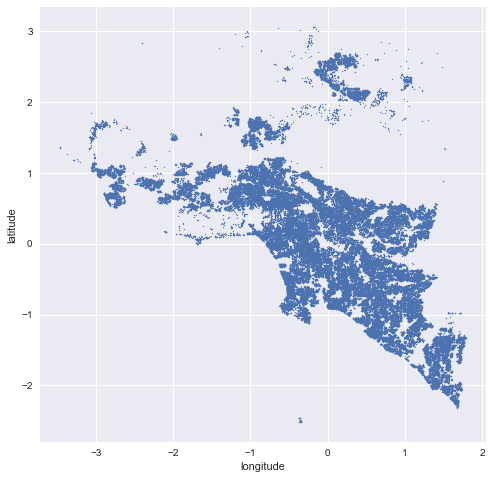

In [12]:
df_ll = copy.deepcopy(df_house16_clean)
df_ll = df_ll[['longitude', 'latitude']]
df_ll.plot.scatter(x='longitude', y='latitude', s=1, figsize=(8,8))

### 3.2.2 Do the Clusting and Visualization

In [19]:
# Compute DBSCAN
X = df_house16_clean

db = DBSCAN(eps=0.3, metric='manhattan', min_samples=40).fit(X)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)

print('Estimated number of clusters: %d' % n_clusters_)

Estimated number of clusters: 85


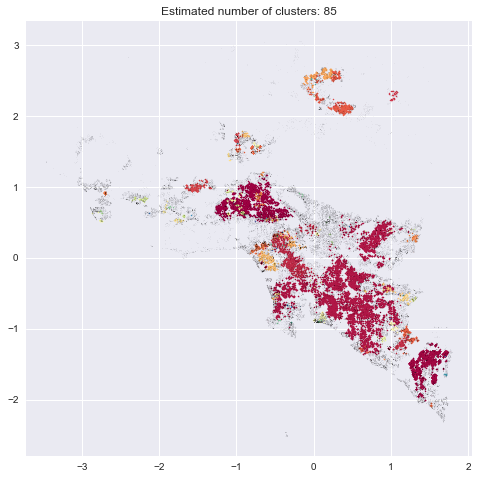

In [20]:
# Plot result
# Black removed and is used for noise instead.
X = X.as_matrix()

plt.figure(figsize=(8,8))
unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)

    xy = X[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=1.5)

    xy = X[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=0.15)

plt.title('Estimated number of clusters: %d' % n_clusters_)

# 4 Task 4: Adding External Data Set

## 4.1 External Data

From current propertites, we can see that there are some properties about geographical information, which includes longtitude, latitude, regionid and so on. But the only useful information is latitude and longitude. The regionid, regioncity and regionzip are masked, from which we can't know houses' geographical information. The only two properties we can use is latitude and longitude, while we don't find enough criminal rates matching these two properties. So after some consideration, we decide not to use the geographical information and turn to some finacial properties related to yearbuilt.

|  | Properties  | Description |
|:--|:--|:--|
|1| latitude| Latitude of the middle of the parcel multiplied by 10e6 |
|2| longitude| Longitude of the middle of the parcel multiplied by 10e6 |
|3| regionidcounty | County in which the property is located |
|4| regionidcity |  City in which the property is located (if any) |
|5| regionidzip |  Zip code in which the property is located |
|6| regionidneighborhood |  Neighborhood in which the property is located |

**First**, we want to use interest rates from 1800 to 2017, but we only obatin data from 1954 to 2017. So it is not suffient for our data analysis. 

**Then** we find that Treasury Rates are available. Since when interest rates go higher, people will turn to government bond, which makes the price of government bond go lower, then the treasury rates become higher. Hence the interest rates are correlated with treasury rates. 

**So** it is reasonalbe to use treasury rates to replace interest rates to analyse the house prices.

### 4.1.1 Import the Data

We can get treasury rates from 1871 to 2017 using data from this website.
[[1]](http://www.multpl.com/10-year-treasury-rate/table/by-year)

In [4]:
treasuryrates = pd.read_csv('../data/treasury rates1.csv')
treasuryrates.columns = ['treasuryrates','yearbuilt']
treasuryrates['yearbuilt']=treasuryrates['yearbuilt'].astype(int)

In [7]:
treasuryrates.describe()

,treasuryrates,yearbuilt
count,148.000000,148.000000
mean,4.538716,1944.493243
std,2.253997,42.856428
min,1.880000,1871.000000
25%,3.297500,1907.750000
50%,3.850000,1944.500000
75%,5.107500,1981.250000
max,14.590000,2017.000000


### 4.1.2 Choose Features

There are properties from 2016 and 2017. We can use these two datasets separately to predict the logerror.

In [9]:
house_df = pd.read_csv('../data/properties_2016.csv')

/Users/xuanxu/anaconda/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (22,32,34,49,55) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [ ]:
house_df = pd.read_csv('../data/properties_2017.csv')

As for chossing properties in data, we choose these four features because they are correlated to logerror. Their correlations are higher than other features.

| Feature | Name  | 
|:--|:--|
|1| bedroomcnt| 
|2| calculatedfinishedsquarefeet| 
|3| yearbuilt | 
|4| structuretaxvaluedollarcnt | 

In [10]:
feature=['parcelid','bedroomcnt','calculatedfinishedsquarefeet','yearbuilt',
         'structuretaxvaluedollarcnt']
feature1=['bedroomcnt','calculatedfinishedsquarefeet','yearbuilt','structuretaxvaluedollarcnt']
house_new_df1=house_df[feature]

After that we can merge these features with the treasury rates.

In [14]:
house_new_df=treasuryrates.merge(house_new_df1, how='left', on='yearbuilt')

There are some lines which missing so many features, so we delete these lines to make the data cleaner.

In [18]:
house_new_df.drop(house_new_df.index[[0,1,2,2925248,2925249,2925250]],inplace=True)

Then fill the blank NaN with mean.

In [19]:
house_new_df=house_new_df.fillna(house_new_df.mean())
house_new_df['parcelid']=house_new_df['parcelid'].astype(int)

Get the train data from datasets.

In [23]:
train_df = pd.read_csv('../data/train_2016_v2.csv')
join_df = train_df.merge(house_new_df, how='left', on='parcelid')

In [ ]:
train_df = pd.read_csv('../data/train_2017.csv')
join_df = train_df.merge(house_new_df, how='left', on='parcelid')

In [25]:
target = join_df.loc[:,'logerror']
feature = join_df.iloc[:,2:]

Use feature to represent the train model, and target to represent the logerror.

Do the type transform for transactiondate. Cause the transactiondate is object and we need float to do the predictions, so we need datetime to transform them.

In [27]:
for num,str in enumerate(feature.transactiondate):
    date_time = datetime.datetime.strptime(str,'%Y-%m-%d')
    st = time.mktime(date_time.timetuple())
    feature.set_value(num,'transactiondate',st)

In [28]:
feature['transactiondate'] = feature['transactiondate'].astype(float)

Also define the date_transform for test data.

In [30]:
def date_transform(df_test):
    for num,str in enumerate(df_test.transactiondate):
        date_time = datetime.datetime.strptime(str,'%Y-%m-%d')
        str = time.mktime(date_time.timetuple())
        df_test.set_value(num,'transactiondate',str)
    df_test['transactiondate'] = df_test['transactiondate'].astype(float) 
    test_matrix = df_test.as_matrix()
    return test_matrix

In [31]:
feature['yearbuilt']=feature['yearbuilt'].astype(float)

Import the sample data.

In [33]:
sample = pd.read_csv("../data/sample_submission.csv")
sample1 = sample.ParcelId
sample1 = sample1.to_frame()
sample1.columns = ['parcelid']
df_test = sample1.merge(house_new_df, on='parcelid', how='left')
df_test['yearbuilt']=df_test['yearbuilt'].astype(float)

fill the test data and feature data with mean.

In [39]:
df_test=df_test.fillna(df_test.mean())
feature=feature.fillna(feature.mean())
#df_test
del df_test['parcelid']

use z_score to normalize the data sets.

In [42]:
z_score_norm(feature,feature1)
z_score_norm(df_test,feature1)

## 4.2 Prediction

In [44]:
model = linear_model.LinearRegression()
model = model.fit(feature, target)

In [51]:
result = sample1.copy()
result.columns = ['ParcelId']
test1 = df_test.copy()
test1.insert(0,'transactiondate','2016-10-15')
test1 = date_transform(test1)
pred1 = model.predict(test1)
pred1 = np.asarray(pred1)
result.insert(1,'201610',pred1)

test2 = df_test.copy()
test2.insert(0,'transactiondate','2016-11-15')
test2 = date_transform(test2)
pred2 = model.predict(test2)
pred2 = np.asarray(pred2)
result.insert(2,'201611',pred2)


test3 = df_test.copy()
test3.insert(0,'transactiondate','2016-12-15')
test3 = date_transform(test3)
pred3 = model.predict(test3)
pred3 = np.asarray(pred3)
result.insert(3,'201612',pred3)


test4 = df_test.copy()
test4.insert(0,'transactiondate','2017-10-15')
test4 = date_transform(test4)
pred4 = model.predict(test4)
pred4 = np.asarray(pred4)
result.insert(4,'201710',pred4)


test5 = df_test.copy()
test5.insert(0,'transactiondate','2017-11-15')
test5 = date_transform(test5)
pred5 = model.predict(test5)
pred5 = np.asarray(pred5)
result.insert(5,'201711',pred5)


test6 = df_test.copy()
test6.insert(0,'transactiondate','2017-12-15')
test6 = date_transform(test6)
pred6 = model.predict(test6)
pred6 = np.asarray(pred6)
result.insert(6,'201712',pred6)

In [52]:
result.columns = ['ParcelId', '201610', '201611', '201612', '201710','201711','201712']
# change filename per run
result.to_csv('../sample 1013 first attempt.csv',index=False,header=True) 

After that we have submit the predictions on Kaggle. Using linear regression without treasury rates gets a score of 0.0650050, while using linear regression with treasury rates gets a score of 0.0649963. 

![fig 1](figure/submission-0.649963.jpg)


![fig 2](figure/submission-0.650050.png)


From these scores, we can see that treasury rates provide a increase on prediction. So we can see that treasury rates can influence the logerror to a certain extent. 
<br>Treasury rates, that is treasury yields which is the return on investment, expressed as a percentage, on the U.S. government's debt obligations (bonds, notes and bills). Looked at another way, the Treasury yield is the interest rate the U.S. government pays to borrow money for different lengths of time.
[[2]](http://www.investopedia.com/terms/t/treasury-yield.asp)
<br> So we can see that the financial situation is related to the people's daily life, which influence the price and logerror. Adding the treasury rates as external data is useful for our predictions.